### Import Libraries

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
import random
import matplotlib as mpl
import pylab
import pandas as pd

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### Read and visualize data
Read train data from csv file
Data was downloaded from https://www.kaggle.com/competitions/diabetic-retinopathy-detection/data

In [115]:

df_train = pd.read_csv('data/trainLabels.csv')
df_train['image'] = 'data/train/' + df_train['image'] + '.jpeg'
df_train = df_train.assign(level_cat=pd.cut(df_train['level'], 
                               bins=[-0.5, 0.5, 1.5, 2.5, 3.5,4.5], 
                               labels=['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferative_DR']))

Read test data from folder

In [116]:
testset = [os.path.join('data/test',img) for img in os.listdir('data/test')]
df_testset = pd.DataFrame(testset, columns=['image'])


Review amount of cases corresponding to each retinopathy level

In [175]:
data_count = df_train.value_counts('level_cat')
print(data_count)

level_cat
No_DR               25810
Moderate             5292
Mild                 2443
Severe                873
Proliferative_DR      708
dtype: int64


Visualization of the amount of cases corresponding to each retinopathy level

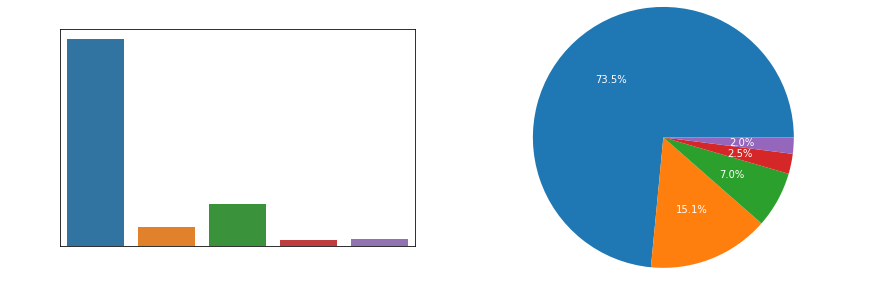

In [178]:
labels = ['No_DR','Moderate','Mild','Severe','Proliferative_DR']
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,4))
sns.countplot(x=df_train['level_cat'].tolist(),ax=axs[0])
axs[1].pie(data_count, labels=labels, autopct='%1.1f%%', radius=1.5)
pylab.ylabel('')
mpl.rcParams['axes.labelcolor'] = 'white'
plt.show()

Visualization of data samples

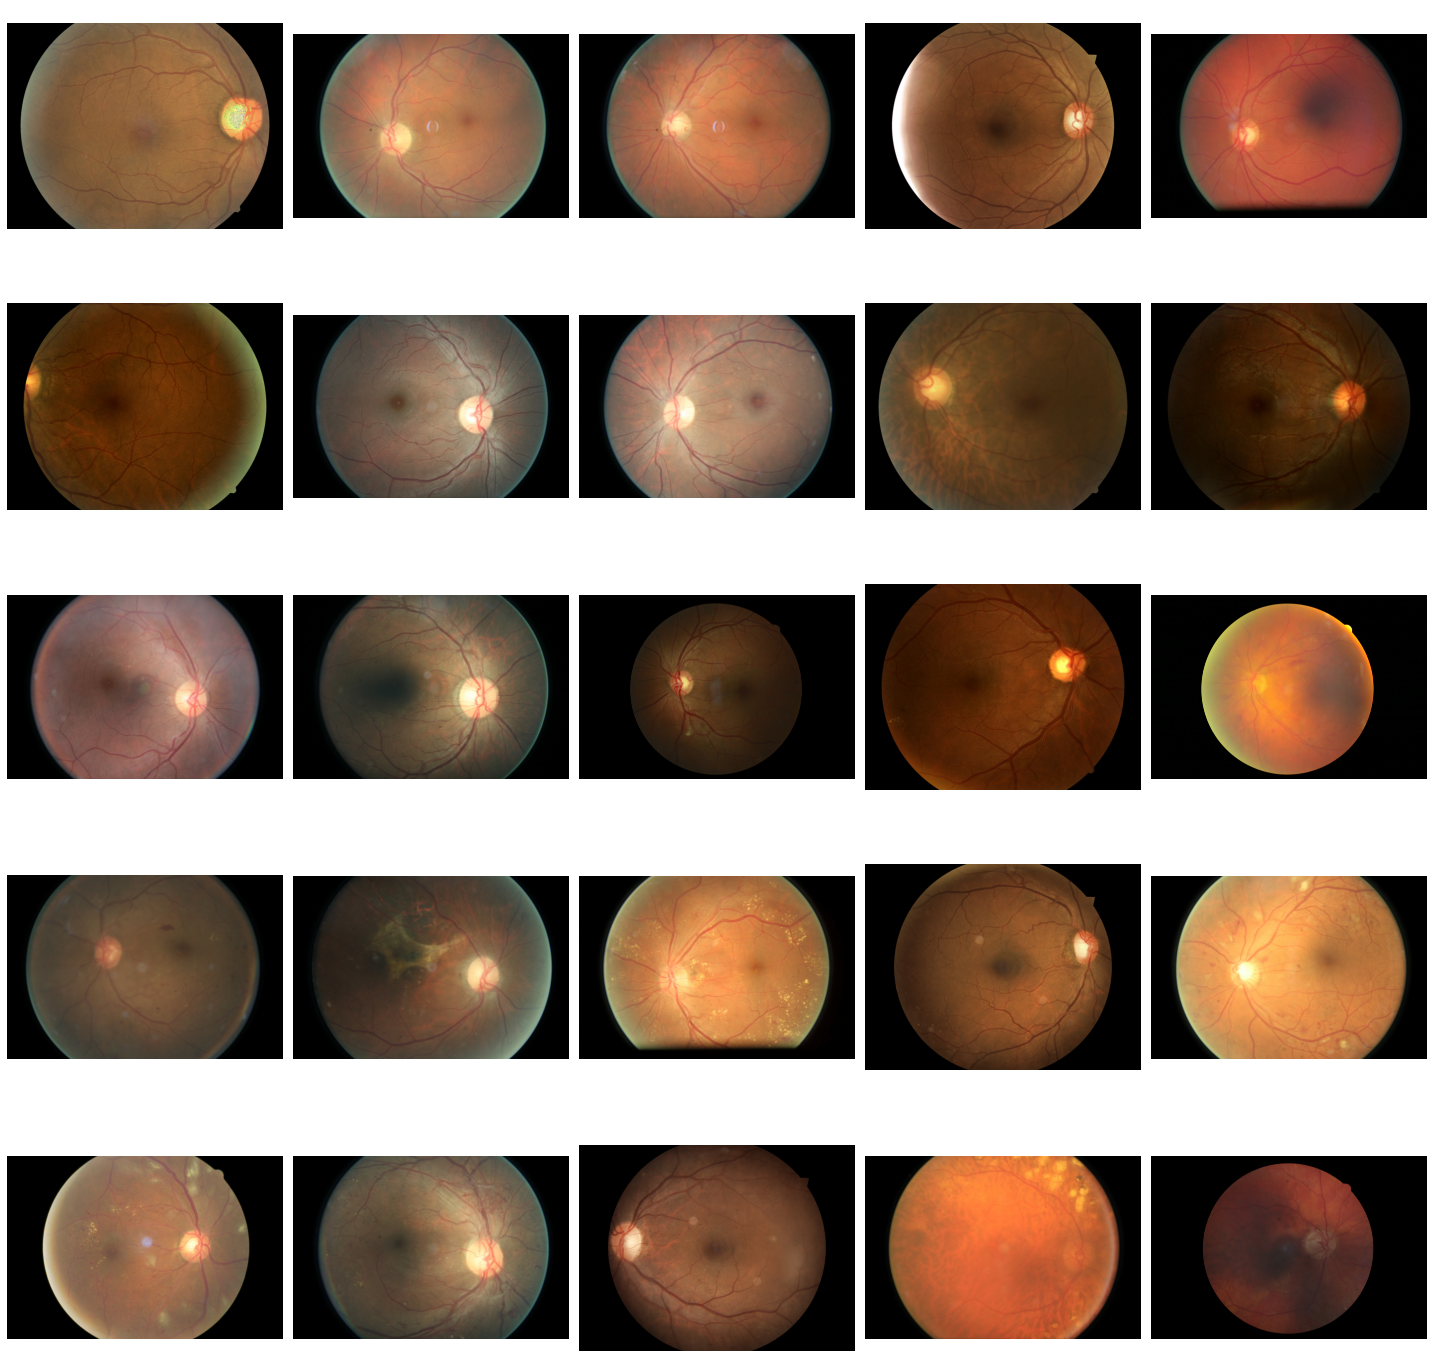

In [120]:
# Visualize 5 images for each class in the dataset

levels = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferative_DR']
fig, axs = plt.subplots(5, 5, figsize = (20, 20))

for l_count, level in enumerate(levels):

  img_level = df_train[df_train['level_cat'] == level]['image'].tolist()
  idx = random.sample(range(0, len(img_level)), 5)
  
  for i_count, i in enumerate(idx):
    img = PIL.Image.open(img_level[i])
    axs[l_count][i_count].title.set_text(level)
    axs[l_count][i_count].imshow(img)  
    axs[l_count][i_count].axis('off')

fig.tight_layout()
plt.show()

### Create Data Generator

In [121]:
# Split data into training and validation set
df_trainset, df_valset = train_test_split(df_train, test_size=0.25, stratify=df_train['level'],random_state=0)

In [179]:
# Add preprocessing and data augmentation 
train_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
        shear_range = 0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        )

val_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
        shear_range = 0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        )

test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [153]:
# Creating datagenerator for training, validation and test dataset.

train_generator = train_datagen.flow_from_dataframe(
    df_trainset,
    directory='./',
    x_col="image",
    y_col="level_cat",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=64)

val_generator = val_datagen.flow_from_dataframe(
    df_valset,
    directory='./',
    x_col="image",
    y_col="level_cat",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=64)

test_generator = test_datagen.flow_from_dataframe(
    df_testset,
    directory='./',
    x_col="image",
    target_size=(256, 256),
    class_mode=None,
    color_mode="rgb",
    batch_size=1)


Found 26344 validated image filenames belonging to 5 classes.
Found 8782 validated image filenames belonging to 5 classes.
Found 53576 validated image filenames.


### Define and Train ResNet18

In [154]:
def res_block(inputs, num_filters, strides, padtype='same'):

    x = Conv2D(num_filters, kernel_size=3, strides=strides[0], padding=padtype)(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, kernel_size=3, strides=strides[1], padding=padtype)(x)
    x = BatchNormalization()(x)

    if strides[0] == 2:
        # Convolutional Block
        xs = Conv2D(num_filters, kernel_size=1, strides=2, padding=padtype)(inputs)
        xs = BatchNormalization()(xs)
    else:
        # Identity Block
        xs = inputs

    # Short Path Connection
    x = Add()([x,xs])
    x = Activation("relu")(x)

    return x

def resnet18(inputs,num_filters=64):

    # 1st Conv
    x = ZeroPadding2D((3,3))(inputs)
    x = Conv2D(num_filters, kernel_size=7, strides=2)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = ZeroPadding2D((1,1))(x)
    x = MaxPool2D(3, strides=2)(x)

    # Residual Blocks
    x = res_block(x, num_filters,[1,1])
    x = res_block(x, num_filters,[1,1])
    
    x = res_block(x, num_filters*2,[2,1])
    x = res_block(x, num_filters*2,[1,1])

    x = res_block(x, num_filters*4,[2,1])
    x = res_block(x, num_filters*4,[1,1])

    x = res_block(x, num_filters*8,[2,1])
    x = res_block(x, num_filters*8,[1,1])

    # Final Layers
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(5, activation='softmax')(x)
    model = Model(inputs, outputs)

    return model

In [180]:
inp_shape = Input(shape=(256,256,3))
model = resnet18(inp_shape)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])
model.summary()


Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_36 (ZeroPadding  (None, 262, 262, 3)  0          ['input_25[0][0]']               
 2D)                                                                                              
                                                                                                  
 conv2d_328 (Conv2D)            (None, 128, 128, 64  9472        ['zero_padding2d_36[0][0]']      
                                )                                                          

In [ ]:
# Define Callbacks and Train Model
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)
history = model.fit(train_generator, batch_size=64, epochs=5, validation_data=val_generator, callbacks=[checkpointer , earlystopping])

### Define and Train ResNet50

In [ ]:
base_model = tf.keras.applications.resnet50.ResNet50(weights = 'imagenet', include_top = False, input_shape = (256,256,3))

for layer in base_model.layers:
  layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(1000, activation='relu')(x)
outputs = Dense(5, activation = 'softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define Callbacks and Train Model
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
checkpointer = ModelCheckpoint(filepath="weightsResNet50.hdf5", verbose=1, save_best_only=True)
history = model.fit(train_generator, batch_size=64, epochs=5, validation_data=val_generator, callbacks=[checkpointer , earlystopping])